In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [14]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()

combined_spy_vix_fear_greed = pd.read_csv('spy_vix_fear_greed_2011_2023.csv')

# Convert 'date' and 'Date' columns to datetime
portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])

# Perform the left join on the 'date' column from df_portfolio and 'Date' column from combined_spy_vix_fear_greed
df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')

# Drop the redundant 'Date' column
df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_comb)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low",'High_VIX','Low_VIX','Close_VIX','High_SPY',
                                'Low_SPY','Close_SPY','Volume_SPY','Fear Greed']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

10



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (27680, 8)


C:\Users\limyi\myenv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
C:\Users\limyi\myenv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
C:\Users\limyi\myenv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated 

In [15]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [32]:
df_portfolio_2023.head(50)

,date,tic,close,high,low,High_VIX,Low_VIX,Close_VIX,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Fear Greed
25180,2023-01-03,AAPL,0.627807,0.655746,0.630305,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25181,2023-01-03,CVX,0.926514,0.943695,0.921205,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25182,2023-01-03,GS,0.842821,0.818003,0.828524,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25183,2023-01-03,JNJ,0.976858,0.955488,0.955641,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25184,2023-01-03,JPM,0.770457,0.790587,0.785094,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25185,2023-01-03,MSFT,0.620523,0.639474,0.627777,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25186,2023-01-03,PFE,0.864077,0.831794,0.849407,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25187,2023-01-03,PG,0.940191,0.917508,0.912607,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25188,2023-01-03,UL,0.863019,0.778532,0.779265,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134
25189,2023-01-03,XOM,0.864687,0.911516,0.892546,0.277992,0.323007,0.276938,0.805096,0.793327,0.797178,0.147563,0.371134


In [33]:
input_features = ['high','low','close','Close_VIX','Close_SPY','Fear Greed']


environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=input_features,
        normalize_df=None
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(input_features),
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [34]:
DRLAgent.train_model(model, episodes=20)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 439797.65625
Final accumulative portfolio value: 4.3979765625
Maximum DrawDown: -0.33626249428526933
Sharpe ratio: 0.9851552496138517


  5%|████▏                                                                              | 1/20 [00:44<13:58, 44.14s/it]

Initial portfolio value:100000
Final portfolio value: 820055.6875
Final accumulative portfolio value: 8.200556875
Maximum DrawDown: -0.31509485393775694
Sharpe ratio: 1.1622904189220478


 10%|████████▎                                                                          | 2/20 [01:30<13:41, 45.62s/it]

Initial portfolio value:100000
Final portfolio value: 852930.0625
Final accumulative portfolio value: 8.529300625
Maximum DrawDown: -0.3198696596462184
Sharpe ratio: 1.176415125901774


 15%|████████████▍                                                                      | 3/20 [02:16<12:59, 45.86s/it]

Initial portfolio value:100000
Final portfolio value: 866191.5625
Final accumulative portfolio value: 8.661915625
Maximum DrawDown: -0.31941268737857154
Sharpe ratio: 1.1852910760894246


 20%|████████████████▌                                                                  | 4/20 [03:03<12:19, 46.24s/it]

Initial portfolio value:100000
Final portfolio value: 878241.875
Final accumulative portfolio value: 8.78241875
Maximum DrawDown: -0.3180924934191257
Sharpe ratio: 1.1944897048072007


 25%|████████████████████▊                                                              | 5/20 [03:50<11:37, 46.51s/it]

Initial portfolio value:100000
Final portfolio value: 893243.3125
Final accumulative portfolio value: 8.932433125
Maximum DrawDown: -0.31593399260733357
Sharpe ratio: 1.2060745376650381


 30%|████████████████████████▉                                                          | 6/20 [04:36<10:45, 46.09s/it]

Initial portfolio value:100000
Final portfolio value: 911967.0625
Final accumulative portfolio value: 9.119670625
Maximum DrawDown: -0.3136378737722736
Sharpe ratio: 1.2199441887905318


 35%|█████████████████████████████                                                      | 7/20 [05:19<09:47, 45.20s/it]

Initial portfolio value:100000
Final portfolio value: 937555.875
Final accumulative portfolio value: 9.37555875
Maximum DrawDown: -0.31110312241023186
Sharpe ratio: 1.2379530911776546


 40%|█████████████████████████████████▏                                                 | 8/20 [06:03<08:59, 44.95s/it]

Initial portfolio value:100000
Final portfolio value: 971291.8125
Final accumulative portfolio value: 9.712918125
Maximum DrawDown: -0.30795410769720766
Sharpe ratio: 1.2610404442970802


 45%|█████████████████████████████████████▎                                             | 9/20 [06:48<08:14, 44.98s/it]

Initial portfolio value:100000
Final portfolio value: 1012147.625
Final accumulative portfolio value: 10.12147625
Maximum DrawDown: -0.30543733676542084
Sharpe ratio: 1.288638910293619


 50%|█████████████████████████████████████████                                         | 10/20 [07:34<07:31, 45.16s/it]

Initial portfolio value:100000
Final portfolio value: 1061313.125
Final accumulative portfolio value: 10.61313125
Maximum DrawDown: -0.3071002206465533
Sharpe ratio: 1.3100798782042837


 55%|█████████████████████████████████████████████                                     | 11/20 [08:20<06:48, 45.41s/it]

Initial portfolio value:100000
Final portfolio value: 1136227.75
Final accumulative portfolio value: 11.3622775
Maximum DrawDown: -0.3108317000512151
Sharpe ratio: 1.3420954717378448


 60%|█████████████████████████████████████████████████▏                                | 12/20 [09:07<06:06, 45.82s/it]

Initial portfolio value:100000
Final portfolio value: 1213887.25
Final accumulative portfolio value: 12.1388725
Maximum DrawDown: -0.31579593246029314
Sharpe ratio: 1.3739466828165507


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [09:53<05:22, 46.12s/it]

Initial portfolio value:100000
Final portfolio value: 1270989.5
Final accumulative portfolio value: 12.709895
Maximum DrawDown: -0.32559242976756964
Sharpe ratio: 1.3862878365504179


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [10:40<04:36, 46.14s/it]

Initial portfolio value:100000
Final portfolio value: 1317418.75
Final accumulative portfolio value: 13.1741875
Maximum DrawDown: -0.3243390535520383
Sharpe ratio: 1.4104424239843036


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [11:23<03:47, 45.41s/it]

Initial portfolio value:100000
Final portfolio value: 1226407.125
Final accumulative portfolio value: 12.26407125
Maximum DrawDown: -0.3534009948850769
Sharpe ratio: 1.337356754186285


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [12:07<02:59, 44.89s/it]

Initial portfolio value:100000
Final portfolio value: 1437937.75
Final accumulative portfolio value: 14.3793775
Maximum DrawDown: -0.34183442759640825
Sharpe ratio: 1.419129437864144


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [12:52<02:14, 44.89s/it]

Initial portfolio value:100000
Final portfolio value: 1364703.25
Final accumulative portfolio value: 13.6470325
Maximum DrawDown: -0.3333991336059111
Sharpe ratio: 1.4189045573072108


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [13:38<01:30, 45.11s/it]

Initial portfolio value:100000
Final portfolio value: 1199054.25
Final accumulative portfolio value: 11.9905425
Maximum DrawDown: -0.36769832940543445
Sharpe ratio: 1.3113090519145068


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [14:23<00:45, 45.11s/it]

Initial portfolio value:100000
Final portfolio value: 1373168.375
Final accumulative portfolio value: 13.73168375
Maximum DrawDown: -0.36311337916570874
Sharpe ratio: 1.369385883791864


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [15:08<00:00, 45.43s/it]


In [35]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

Evaluation

In [36]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=input_features,
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=input_features,
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=input_features,
    normalize_df=None
)

EIIE_results = {
    "training": environment._asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device,initial_features=len(input_features) )
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

C:\Users\limyi\AppData\Local\Temp\ipykernel_8856\3093999190.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


Initial portfolio value:100000
Final portfolio value: 107672.015625
Final accumulative portfolio value: 1.07672015625
Maximum DrawDown: -0.1677062954788927
Sharpe ratio: 0.48175752395301413
Initial portfolio value:100000
Final portfolio value: 119884.8671875
Final accumulative portfolio value: 1.198848671875
Maximum DrawDown: -0.10931061300136757
Sharpe ratio: 1.0731677775575326
Initial portfolio value:100000
Final portfolio value: 99730.8671875
Final accumulative portfolio value: 0.997308671875
Maximum DrawDown: -0.15941063404461397
Sharpe ratio: 0.04312818295355247
Initial portfolio value:100000
Final portfolio value: 259608.09375
Final accumulative portfolio value: 2.5960809375
Maximum DrawDown: -0.3467876931323318
Sharpe ratio: 0.7827855024573748
Initial portfolio value:100000
Final portfolio value: 122309.3203125
Final accumulative portfolio value: 1.223093203125
Maximum DrawDown: -0.0481939713772489
Sharpe ratio: 2.2707143284341953
Initial portfolio value:100000
Final portfolio v

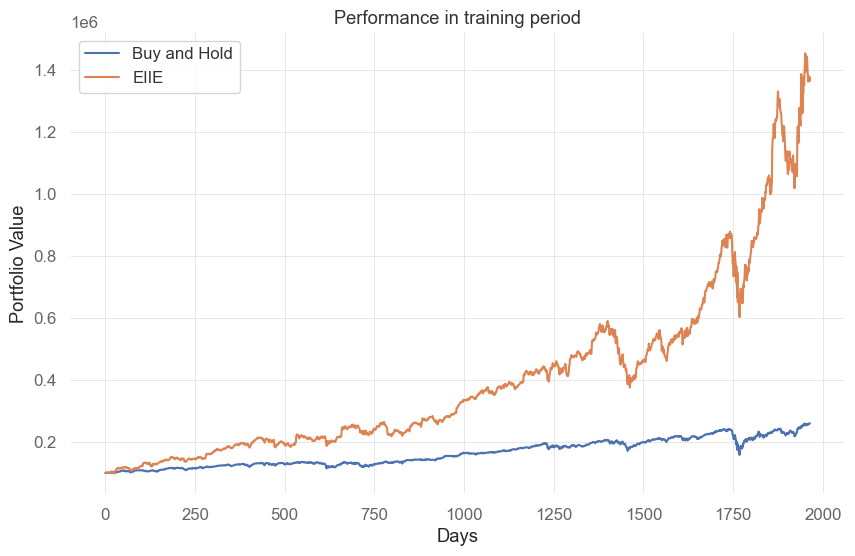

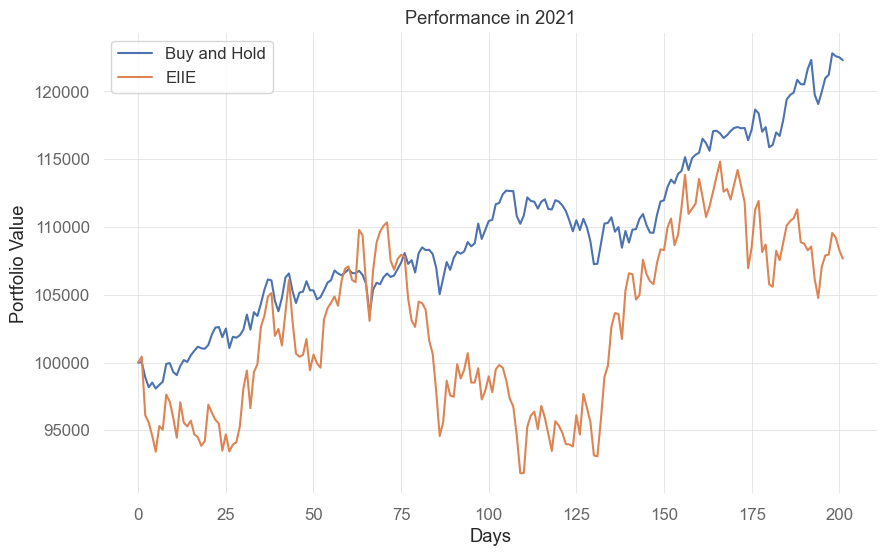

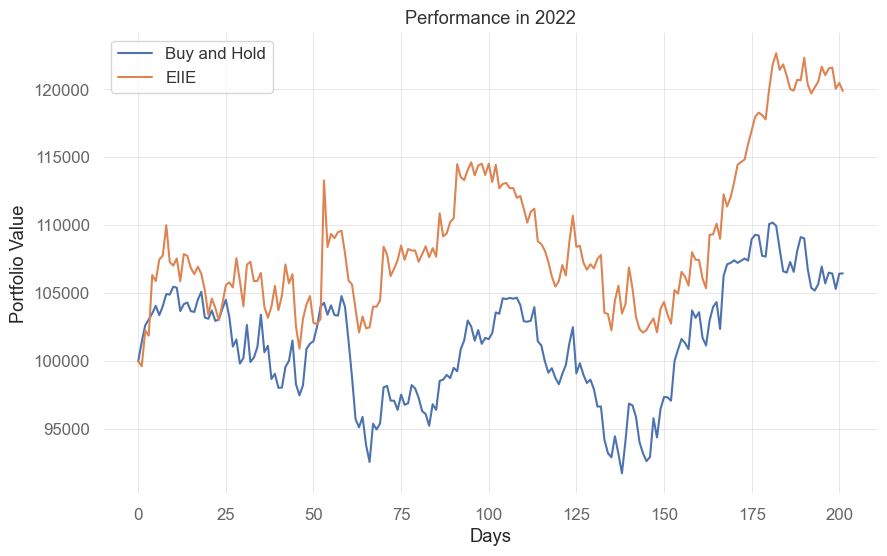

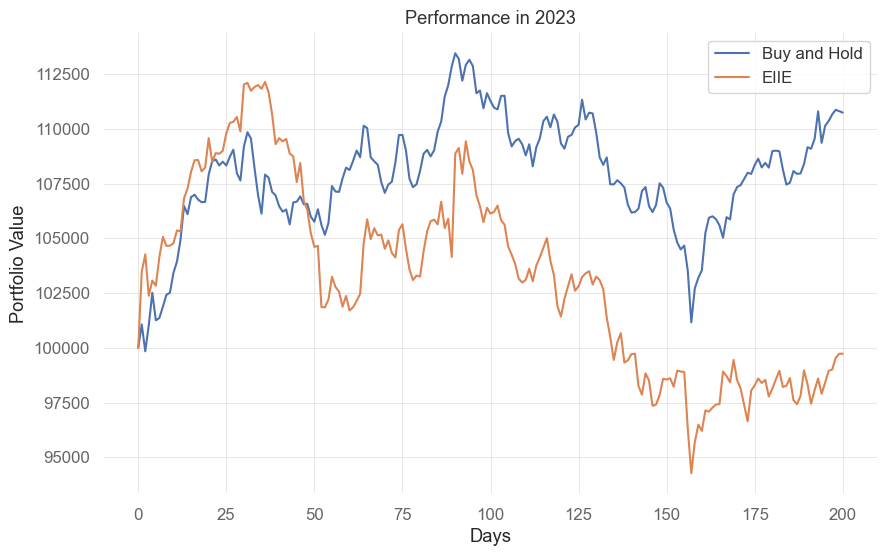

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()